In [1]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import GCNConv

from sklearn.mixture import GaussianMixture 

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def loadData(file):
    data = pd.read_csv(file)
    print('Raw shape: ',data.shape)
    data['date'] = pd.to_datetime(data.date)
    print('Days: ',len(set(data.date)))
    return data

In [3]:
def getTimeSeries(df):
    table = pd.pivot_table(df, values='amount', index=['date'],
                    columns=['start_id','end_id'], aggfunc=np.sum, fill_value=0)
    return table

In [4]:
dataDir = '/home/urwa/Documents/Projects/AnomalyDetection/Pipeline/data/'
dataFile = '20190402_TaipeiEdgesDatewise.csv'
events_data =dataDir+'TaipeiEvents.csv'

In [5]:
file = dataDir + dataFile
dataRaw = loadData(file)

Raw shape:  (7374816, 5)
Days:  638


In [6]:
dataIn =  pd.pivot_table(dataRaw, values='amount', index=['date'],
                    columns=['end_id'], aggfunc=np.sum, fill_value=0)
dataIn.head(1)

end_id,BL01,BL02,BL03,BL04,BL05,BL06,BL07,BL08,BL09,BL10,...,R20,R21,R22,R22A,R23,R24,R25,R26,R27,R28
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,6326,11444,5696,16834,12256,25559,45609,27781,18745,33240,...,5597,5937,15733,12194,2972,2067,9518,8439,6473,73538


In [7]:
dataOut =  pd.pivot_table(dataRaw, values='amount', index=['date'],
                    columns=['start_id'], aggfunc=np.sum, fill_value=0)
dataOut.head(1)

start_id,BL01,BL02,BL03,BL04,BL05,BL06,BL07,BL08,BL09,BL10,...,R20,R21,R22,R22A,R23,R24,R25,R26,R27,R28
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,6292,10268,5591,15834,12955,26456,42135,29606,18572,34387,...,5734,6801,14919,12373,2943,1957,8887,8603,6870,76751


In [8]:
matrix = np.stack((dataOut.values, dataIn.values),-1)
matrix = matrix.astype(float)
matrix.shape

(638, 108, 2)

In [9]:
for i in range(matrix.shape[1]):
    for j in range(matrix.shape[2]):
        matrix[:, i,j] = (matrix[:, i,j] - np.mean(matrix[:, i,j])) / (np.std(matrix[:, i,j]))

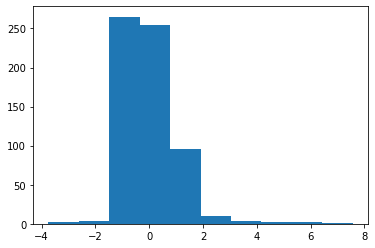

In [10]:
_ = plt.hist(matrix[:,10,1])

In [11]:
stations = list(set(dataRaw.start_id))
n= len(stations)
edge_index = [[a//n,a%n] for a in range(n*n)]
edge_index = torch.tensor(edge_index, dtype=torch.long)

In [12]:
dates = list(dataOut.index)
DOW = list(pd.to_datetime(dataOut.index.values).dayofweek)
DOW = ((np.array(DOW) == 5) | (np.array(DOW) == 6)).astype(int)
DOW[:10]

array([1, 0, 0, 0, 0, 0, 1, 1, 0, 0])

In [13]:
dataList = []

for i in range(len(DOW)):
    x = torch.tensor(matrix[i], dtype=torch.float)
    y = torch.tensor(np.array([DOW[i]]), dtype=torch.long)
    data = Data(x=x, edge_index=edge_index.t().contiguous(),y=y)
    dataList.append(data)

dataList[0]

Data(edge_index=[2, 11664], x=[108, 2], y=[1])

In [14]:
n_classes = 2
featureDim = 2
hiddenDim = [8,16,20]

In [15]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(featureDim, hiddenDim[0])
        self.conv2 = GCNConv(hiddenDim[0], hiddenDim[1])
        self.linear1 = nn.Linear(n*hiddenDim[1], hiddenDim[2])
        self.linear2 = nn.Linear(hiddenDim[2], n_classes)

        self.init_weights(self.linear1)
        self.init_weights(self.linear2)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = x.view(-1,n*hiddenDim[1])
        x = self.linear1(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.linear2(x)
        return F.log_softmax(x, dim=1)
        
    def init_weights(self,m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
    
    def representation(self, x):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = x.view(-1,n*hiddenDim[1])
        x = self.linear1(x)
        return x
            

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
model = Net().to(device)
#data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

In [17]:
device

device(type='cuda')

In [18]:
#optimizer = torch.optim.Adam(model.parameters(), lr=0.00001, weight_decay=5e-4)
num_epochs = 200

In [19]:
model.train()

for epoch in range(num_epochs):
    epochLoss = 0
    for data in dataList:
        #data.view(1,-1,-1)
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
#         print(out.shape)
#         print(data.y.shape)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        
        epochLoss += loss.item()
    
#     if epoch == 500:
#         optimizer = torch.optim.Adam(model.parameters(), lr=0.00001, weight_decay=5e-4)
        
    print('epoch [{}/{}], loss:{:.4f}'
    .format(epoch + 1, num_epochs, loss.item()))

torch.Size([1, 2])
torch.Size([1])
torch.Size([1, 2])
torch.Size([1])
torch.Size([1, 2])
torch.Size([1])
torch.Size([1, 2])
torch.Size([1])
torch.Size([1, 2])
torch.Size([1])
torch.Size([1, 2])
torch.Size([1])
torch.Size([1, 2])
torch.Size([1])
torch.Size([1, 2])
torch.Size([1])
torch.Size([1, 2])
torch.Size([1])
torch.Size([1, 2])
torch.Size([1])
torch.Size([1, 2])
torch.Size([1])
torch.Size([1, 2])
torch.Size([1])
torch.Size([1, 2])
torch.Size([1])
torch.Size([1, 2])
torch.Size([1])
torch.Size([1, 2])
torch.Size([1])
torch.Size([1, 2])
torch.Size([1])
torch.Size([1, 2])
torch.Size([1])
torch.Size([1, 2])
torch.Size([1])
torch.Size([1, 2])
torch.Size([1])
torch.Size([1, 2])
torch.Size([1])
torch.Size([1, 2])
torch.Size([1])
torch.Size([1, 2])
torch.Size([1])
torch.Size([1, 2])
torch.Size([1])
torch.Size([1, 2])
torch.Size([1])
torch.Size([1, 2])
torch.Size([1])
torch.Size([1, 2])
torch.Size([1])
torch.Size([1, 2])
torch.Size([1])
torch.Size([1, 2])
torch.Size([1])
torch.Size([1, 2])
t

KeyboardInterrupt: 

In [20]:
model.eval()
with torch.no_grad():
    y = DOW
    predList = []
    for data in dataList:
        data = data.to(device)
        pred = model(data).cpu().numpy()
        predList.append(np.argmax(pred))
    
    print('Accuracy: {:.4f}'.format( np.sum(np.array(predList) == np.array(y)) / len(predList) ))

Accuracy: 0.8840


In [21]:
representation = np.empty((matrix.shape[0],hiddenDim[2]))
representationR = np.empty((matrix.shape[0],hiddenDim[2]))
prediction = np.empty((matrix.shape[0],n_classes))
model.eval()
with torch.no_grad():
    for i,data in enumerate(dataList):
        data = data.to(device)
        representation[i] = model.representation(data).cpu().numpy()
        representationR[i] = model.representationR(data).cpu().numpy()
        prediction[i] = model(data).cpu().numpy()
        predList.append(np.argmax(pred))

In [22]:
representation.shape

(638, 20)

In [23]:
prediction.shape

(638, 2)

In [24]:
# import events data
events_data =dataDir+'TaipeiEvents.csv'
df_events = pd.read_csv(events_data, encoding = "ISO-8859-1", parse_dates=['Date'], infer_datetime_format=True)


In [25]:
df_events.head()

,Type,Name,Date
0,National holiday,Republic Day/New Year's Day observed,2017-01-02
1,National holiday,Chinese New Year's Eve,2017-01-27
2,National holiday,Chinese New Year's Day,2017-01-28
3,National holiday,Chinese New Year Holiday 1,2017-01-29
4,National holiday,Chinese New Year Holiday 2,2017-01-30


In [26]:
holidayDates = df_events[df_events.Type == 'National holiday'].Date

In [27]:
holidayDates = [str(d.date()) for d in holidayDates]
dates = [str(d.date()) for d in dates]

In [28]:
anomalyIndex = [i for i,d in enumerate(dates) if d in holidayDates]
len(anomalyIndex)
indexBool = np.array([i in anomalyIndex for i in list(range(matrix.shape[0]))])

In [29]:
def anomalyDetection(y,pval = 0.2,iterN=5,n_com=1):
    #index of regular (non-outlier points)
    #rind=y[:,0]>-10 
    rind = np.array(range(y.shape[0]))
    
    #clustering model
    gm=GaussianMixture(n_components=n_com, n_init=100, max_iter=1000,random_state=0) 
    for i in range(iterN): #iterate
        print('Iteration {}'.format(i+1))  
        clustering=gm.fit(y[rind,:]) #fit EM clustering model excluding outliers
        l=clustering.score_samples(y) #estimate likelihood for each point
        Lthres=sorted(l)[int(len(l)*pval)] #anomaly threshold
        rind0=0+rind
        rind=l>Lthres #non-anomalous points
        if all(rind==rind0):
            print('Convergence in {} iterations'.format(i+1))
            break
    return l < Lthres

In [30]:
def getResults(reducedMatrix,threshHolds,iterN=5,n_com=1):
    results = []
    for th in threshHolds:
        #th = thres/100
        print("Threshhold: ",th)
        outliers = anomalyDetection(reducedMatrix,th,iterN,n_com)

        tpr = sum(outliers & indexBool)/sum(indexBool)
        fpr = sum(outliers & ~indexBool)/sum(~indexBool)
        precision = sum(outliers & indexBool)/sum(outliers)

        F1 = 2 * (precision * tpr) / (precision + tpr)

        res = {'Cat':'Global', 'th':th, 'TPR':tpr, 'FPR':fpr, 'F1':F1, 'Precision':precision}
        results.append(res)

    resDf = pd.DataFrame(results)    
    return resDf

In [31]:
threshHolds = [0.01, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [32]:
Res1 = getResults(representation,threshHolds,iterN=5,n_com=1)

Threshhold:  0.01
Iteration 1
Iteration 2
Convergence in 2 iterations
Threshhold:  0.03
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Threshhold:  0.04
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Threshhold:  0.05
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Threshhold:  0.06
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Threshhold:  0.07
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Threshhold:  0.08
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Threshhold:  0.1
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Threshhold:  0.2
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Threshhold:  0.3
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Threshhold:  0.4
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Threshhold:  0.5
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Convergence in 4 iterations
Threshhold:  0.6
Iteration 1
Iteration 2
Iteration 3
Iteratio

In [33]:
Res1

,Cat,F1,FPR,Precision,TPR,th
0,Global,0.228571,0.003284,0.666667,0.137931,0.01
1,Global,0.458333,0.013136,0.578947,0.379310,0.03
2,Global,0.481481,0.019704,0.520000,0.448276,0.04
3,Global,0.533333,0.024631,0.516129,0.551724,0.05
4,Global,0.507463,0.034483,0.447368,0.586207,0.06
5,Global,0.465753,0.044335,0.386364,0.586207,0.07
6,Global,0.450000,0.054187,0.352941,0.620690,0.08
7,Global,0.434783,0.070608,0.317460,0.689655,0.10
8,Global,0.307692,0.169130,0.188976,0.827586,0.20
9,Global,0.236364,0.270936,0.136126,0.896552,0.30


In [34]:
Res2 = getResults(representationR,threshHolds,iterN=5,n_com=1)

Threshhold:  0.01
Iteration 1
Iteration 2
Convergence in 2 iterations
Threshhold:  0.03
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Threshhold:  0.04
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Threshhold:  0.05
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Threshhold:  0.06
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Threshhold:  0.07
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Threshhold:  0.08
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Threshhold:  0.1
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Threshhold:  0.2
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Threshhold:  0.3
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Threshhold:  0.4
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Threshhold:  0.5
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Convergence in 4 iterations
Threshhold:  0.6
Iteration 1
Iteration 2
Iteration 3
Iteratio

In [35]:
Res2

,Cat,F1,FPR,Precision,TPR,th
0,Global,0.228571,0.003284,0.666667,0.137931,0.01
1,Global,0.458333,0.013136,0.578947,0.379310,0.03
2,Global,0.481481,0.019704,0.520000,0.448276,0.04
3,Global,0.533333,0.024631,0.516129,0.551724,0.05
4,Global,0.507463,0.034483,0.447368,0.586207,0.06
5,Global,0.465753,0.044335,0.386364,0.586207,0.07
6,Global,0.450000,0.054187,0.352941,0.620690,0.08
7,Global,0.434783,0.070608,0.317460,0.689655,0.10
8,Global,0.307692,0.169130,0.188976,0.827586,0.20
9,Global,0.236364,0.270936,0.136126,0.896552,0.30


In [36]:
Res3 = getResults(prediction,threshHolds,iterN=5,n_com=1)

Threshhold:  0.01
Iteration 1
Iteration 2
Convergence in 2 iterations
Threshhold:  0.03
Iteration 1
Iteration 2
Convergence in 2 iterations
Threshhold:  0.04
Iteration 1
Iteration 2
Convergence in 2 iterations
Threshhold:  0.05
Iteration 1
Iteration 2
Convergence in 2 iterations
Threshhold:  0.06
Iteration 1
Iteration 2
Convergence in 2 iterations
Threshhold:  0.07
Iteration 1
Iteration 2
Convergence in 2 iterations
Threshhold:  0.08
Iteration 1
Iteration 2
Convergence in 2 iterations
Threshhold:  0.1
Iteration 1
Iteration 2
Iteration 3
Convergence in 3 iterations
Threshhold:  0.2
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Convergence in 4 iterations
Threshhold:  0.3
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Convergence in 4 iterations
Threshhold:  0.4
Iteration 1
Iteration 2
Iteration 3
Convergence in 3 iterations
Threshhold:  0.5
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Convergence in 5 iterations
Threshhold:  0.6
Iteration 1
Iteration 2
Iteration 3
Iter

In [37]:
Res3

,Cat,F1,FPR,Precision,TPR,th
0,Global,0.057143,0.008210,0.166667,0.034483,0.01
1,Global,0.166667,0.024631,0.210526,0.137931,0.03
2,Global,0.148148,0.034483,0.160000,0.137931,0.04
3,Global,0.133333,0.044335,0.129032,0.137931,0.05
4,Global,0.119403,0.055829,0.105263,0.137931,0.06
5,Global,0.109589,0.065681,0.090909,0.137931,0.07
6,Global,0.100000,0.077176,0.078431,0.137931,0.08
7,Global,0.086957,0.096880,0.063492,0.137931,0.10
8,Global,0.141026,0.190476,0.086614,0.379310,0.20
9,Global,0.254545,0.267652,0.146597,0.965517,0.30
